# Generation

### Import

In [3]:
%load_ext autoreload
%autoreload 2

import os
PROJECT_PATH = "/projects/compures/alexandre/disdiff_adapters"
os.chdir(PROJECT_PATH)
print(os.getcwd())

import numpy as np
from collections import Counter, defaultdict
from math import log
import seaborn as sns
from glob import glob
import json
from pathlib import Path

import torch
from torch.utils.data import DataLoader, TensorDataset
from lightning import Trainer

from tqdm import tqdm

#DataModule
from disdiff_adapters.data_module import *
#Dataset
from disdiff_adapters.dataset import *
#Module
from disdiff_adapters.arch.multi_distillme import *
#utils
from disdiff_adapters.utils import *
#loss   
from disdiff_adapters.loss import *
#metric
from disdiff_adapters.metric import FactorVAEScore

from disdiff_adapters.arch.multi_distillme.xfactors import Xfactors
BATCH_SIZE = 2**19
LATENT_DIM_S = 126
LATENT_DIM_T = 2
is_pca = False

torch.set_float32_matmul_precision('medium')

/import/pr_compures/alexandre/disdiff_adapters


/projects/compures/alexandre/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data 

**Choose the appropriate set :**

### 3DShapes

In [27]:
images = torch.load("/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/data/3dshapes/images_train_buff.pt")
labels = torch.load("/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/data/3dshapes/labels_train_buff.pt")

/tmp/ipykernel_3193475/3901164338.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  images = torch.load("/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/dat

In [28]:
images.dtype, images.max(), images.min()

(torch.float32, tensor(1.), tensor(0.))

### CelebA

In [32]:
import numpy as np
import torch

def ensure_nchw(images: torch.Tensor) -> torch.Tensor:
    images = torch.as_tensor(images)

    if images.ndim == 4:
        # déjà NCHW
        if images.shape[1] in (1, 3):
            pass
        # NHWC -> NCHW
        elif images.shape[-1] in (1, 3):
            images = images.permute(0, 3, 1, 2)
        else:
            raise ValueError(f"Ambiguous images shape: {tuple(images.shape)} (neither NCHW nor NHWC).")
    elif images.ndim == 3:
        # CHW -> NCHW
        if images.shape[0] in (1, 3):
            images = images.unsqueeze(0)
        # HWC -> NCHW
        elif images.shape[-1] in (1, 3):
            images = images.permute(2, 0, 1).unsqueeze(0)
        else:
            raise ValueError(f"Ambiguous image shape: {tuple(images.shape)} (neither CHW nor HWC).")
    else:
        raise ValueError(f"Expected 3D or 4D tensor, got {images.ndim}D")

    return images.contiguous()

# --- load ---
celeba = np.load("/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/data/celeba/celeba_val.npz")
images_np, labels_np = celeba["images"], celeba["labels"]

images = ensure_nchw(images_np)

# normalisation en [0,1]
if images.dtype == torch.uint8:
    images = images.float() / 255.0
else:
    images = images.float()
    if images.max() > 1.5:  # cas fréquent: [0,255] en float
        images = images / 255.0

labels = torch.as_tensor(labels_np)
# labels souvent int/long
if labels.dtype not in (torch.int64, torch.int32, torch.int16, torch.uint8):
    labels = labels.long()

print("images:", images.shape, images.dtype, images.min().item(), images.max().item())
print("labels:", labels.shape, labels.dtype)


images: torch.Size([19962, 3, 64, 64]) torch.float32 0.0 1.0
labels: torch.Size([19962, 40]) torch.int64


### DSprites

In [22]:
def ensure_nchw(images) -> torch.Tensor:
    x = torch.as_tensor(images)

    # --- 2D: HW -> 1,1,H,W
    if x.ndim == 2:
        return x.unsqueeze(0).unsqueeze(0).contiguous()

    # --- 3D cases ---
    if x.ndim == 3:
        # NHW (dsprites-like): N,H,W  -> N,1,H,W
        # Heuristic: first dim is "N" if it's large and last two look like H,W
        if x.shape[-1] > 4 and x.shape[-2] > 4 and x.shape[0] > 4 and x.shape[-1] == x.shape[-2]:
            # This catches (N,H,W) with square images (64,64), typical dsprites
            return x.unsqueeze(1).contiguous()

        # CHW: C,H,W -> 1,C,H,W
        if x.shape[0] in (1, 3):
            return x.unsqueeze(0).contiguous()

        # HWC: H,W,C -> 1,C,H,W
        if x.shape[-1] in (1, 3):
            return x.permute(2, 0, 1).unsqueeze(0).contiguous()

        raise ValueError(f"Ambiguous 3D shape {tuple(x.shape)} (not NHW/CHW/HWC).")

    # --- 4D cases ---
    if x.ndim == 4:
        # NCHW
        if x.shape[1] in (1, 3):
            return x.contiguous()
        # NHWC -> NCHW
        if x.shape[-1] in (1, 3):
            return x.permute(0, 3, 1, 2).contiguous()
        raise ValueError(f"Ambiguous 4D shape {tuple(x.shape)} (not NCHW/NHWC).")

    raise ValueError(f"Expected 2D/3D/4D tensor, got {x.ndim}D with shape {tuple(x.shape)}")



dsprites = np.load("/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/data/dsprites/dsprites_val.npz")
images_np, labels_np = dsprites["images"], dsprites["labels"]

images = ensure_nchw(images_np).float()  # -> [N,1,64,64]

labels = torch.as_tensor(labels_np).long()

print("images:", images.shape, images.dtype, images.min().item(), images.max().item())
print("labels:", labels.shape, labels.dtype)



images: torch.Size([117965, 1, 64, 64]) torch.float32 0.0 1.0
labels: torch.Size([117965, 5]) torch.int64


In [25]:
perm = torch.randperm(117965)
images = images[perm]
labels = labels[perm]

### Mpi3D

In [1]:
import numpy as np
import torch

def ensure_nchw(images: torch.Tensor) -> torch.Tensor:
    images = torch.as_tensor(images)

    if images.ndim == 4:
        # déjà NCHW
        if images.shape[1] in (1, 3):
            pass
        # NHWC -> NCHW
        elif images.shape[-1] in (1, 3):
            images = images.permute(0, 3, 1, 2)
        else:
            raise ValueError(f"Ambiguous images shape: {tuple(images.shape)} (neither NCHW nor NHWC).")
    elif images.ndim == 3:
        # CHW -> NCHW
        if images.shape[0] in (1, 3):
            images = images.unsqueeze(0)
        # HWC -> NCHW
        elif images.shape[-1] in (1, 3):
            images = images.permute(2, 0, 1).unsqueeze(0)
        else:
            raise ValueError(f"Ambiguous image shape: {tuple(images.shape)} (neither CHW nor HWC).")
    else:
        raise ValueError(f"Expected 3D or 4D tensor, got {images.ndim}D")

    return images.contiguous()

# --- load ---
mpi3d = np.load("/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/data/mpi3d/mpi3d_val.npz")
images_np, labels_np = mpi3d["images"], mpi3d["labels"]

images = ensure_nchw(images_np)

# normalisation en [0,1]
if images.dtype == torch.uint8:
    images = images.float() / 255.0
else:
    images = images.float()
    if images.max() > 1.5:  # cas fréquent: [0,255] en float
        images = images / 255.0

labels = torch.as_tensor(labels_np)
# labels souvent int/long
if labels.dtype not in (torch.int64, torch.int32, torch.int16, torch.uint8):
    labels = labels.long()

print("images:", images.shape, images.dtype, images.min().item(), images.max().item())
print("labels:", labels.shape, labels.dtype)


images: torch.Size([100000, 3, 64, 64]) torch.float32 0.0 1.0
labels: torch.Size([100000, 7]) torch.int64


### Load XFactors

In [4]:
ckpt_path_x = load_json(Path("ckpt_path_x.json"))

In [24]:
xfactors = Xfactors.load_from_checkpoint(ckpt_path_x["126"]["mpi3d"]["bt100"]["bs100"]["n-1"],
                                        map_location={"cuda:3": "cuda:0"}).to("cuda:0")

#### Merge 2 images

In [68]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
from typing import Any

def _to_bchw(images: torch.Tensor) -> torch.Tensor:
    """Accept CHW, HWC, BCHW, BHWC -> return BCHW."""
    if images.ndim == 3:
        # CHW
        if images.shape[0] in (1, 3):
            return images.unsqueeze(0)
        # HWC
        if images.shape[-1] in (1, 3):
            return images.permute(2, 0, 1).unsqueeze(0)
        raise ValueError(f"Ambiguous image shape {tuple(images.shape)} (not CHW/HWC).")

    if images.ndim == 4:
        # BCHW
        if images.shape[1] in (1, 3):
            return images
        # BHWC
        if images.shape[-1] in (1, 3):
            return images.permute(0, 3, 1, 2)
        raise ValueError(f"Ambiguous batch shape {tuple(images.shape)} (not BCHW/BHWC).")

    raise ValueError(f"Expected 3D or 4D images, got {images.ndim}D with shape {tuple(images.shape)}")

def display(batch: tuple[Any, Any], max_images: int | None = None) -> None:
    """
    batch = (images, labels)
    images can be CHW/HWC/BCHW/BHWC, torch or numpy/list-like.
    labels can be tensor/numpy/list-like.
    """
    images, labels = batch

    images = torch.as_tensor(images)
    labels = torch.as_tensor(labels) if labels is not None else None

    images = _to_bchw(images)

    if max_images is not None:
        images = images[:max_images]
        if labels is not None and labels.ndim > 0:
            labels = labels[:max_images]

    # tout sur CPU pour éviter des transferts répétitifs
    images = images.detach().cpu()
    if labels is not None:
        labels = labels.detach().cpu()

    nb_samples = images.size(0)
    nb_col = math.ceil(math.sqrt(nb_samples))
    nb_row = math.ceil(nb_samples / nb_col)

    fig, axes = plt.subplots(nb_row, nb_col, figsize=(3 * nb_col, 3 * nb_row))
    axes = np.array(np.atleast_1d(axes), dtype=object).reshape(nb_row, nb_col)

    for i in range(nb_row * nb_col):
        r, c = divmod(i, nb_col)
        ax = axes[r, c]
        ax.axis("off")

        if i >= nb_samples:
            continue

        img = images[i]  # C,H,W

        # min-max -> uint8 (robuste même si image constante)
        img_f = img.float()
        mn, mx = img_f.min(), img_f.max()
        img_u8 = (255 * (img_f - mn) / (mx - mn + 1e-8)).to(torch.uint8)

        if img_u8.size(0) == 3:
            ax.imshow(img_u8.permute(1, 2, 0).numpy())
        else:
            ax.imshow(img_u8[0].numpy(), cmap="gray")

        if labels is not None:
            lbl = labels[i]
            ax.set_title(str(lbl.item()) if lbl.ndim == 0 else str(lbl.numpy()))

    plt.tight_layout()
    plt.show()


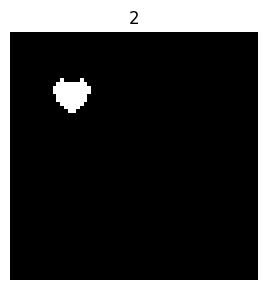

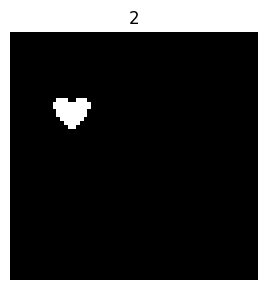

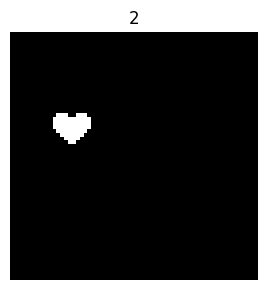

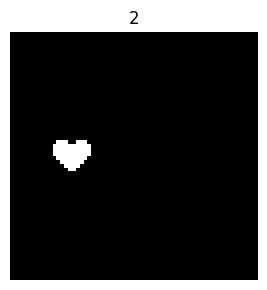

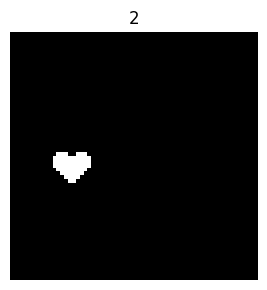

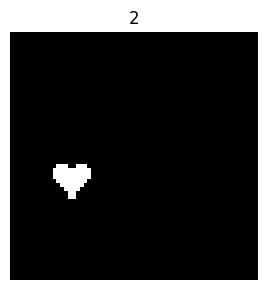

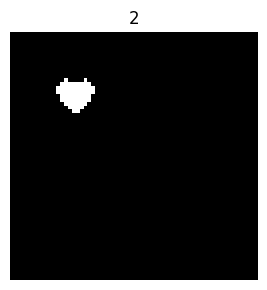

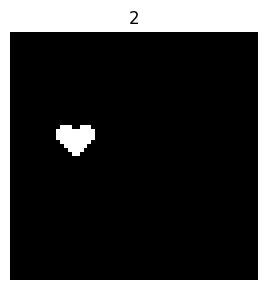

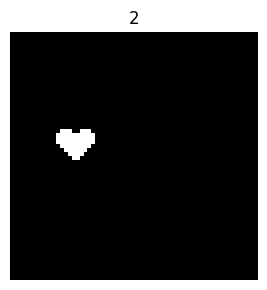

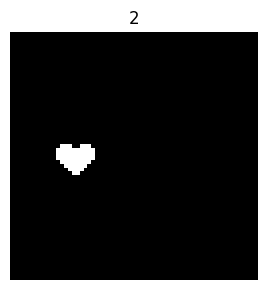

In [30]:
src_idx = (labels[:, 0] == 2)
for i in range(10) :
    display((images[src_idx][i], labels[src_idx][i]))

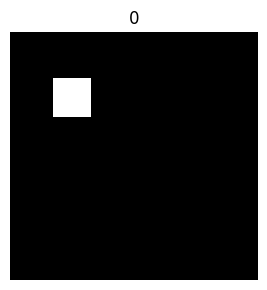

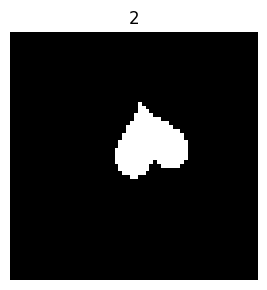

The factor encoded chose is shape


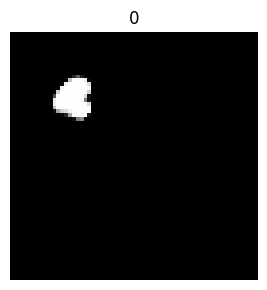

In [34]:
src_idx = 0
tgt_idx = 115000
select_factor = 0
display((images[src_idx], labels[src_idx, select_factor].unsqueeze(0)))
display((images[tgt_idx], labels[tgt_idx, select_factor].unsqueeze(0)))
new = xfactors.merge(images[src_idx], images[tgt_idx], select_factor)
display((new, torch.tensor([0])))

### Mosaic

In [6]:
import torch
import torchvision.utils as vutils
from PIL import Image, ImageDraw, ImageFont

@torch.no_grad()
def save_merge_mosaic_jpg(
    xfactors,
    images: torch.Tensor,
    source_idxs=(0, 40000, 70000, 100000, 115000),
    target_idx=24569,
    factors=None,                 # liste des select_factor à tester (ceux que merge() attend)
    save_path="mosaic.jpg",
    padding=2,
    pad_value=0,
    left_margin=140,              # marge gauche en pixels pour écrire les labels
    font_size=None,               # si None -> auto à partir de H
    font_path=None,               # optionnel: path vers .ttf
    text_color=(0, 0, 0),         # noir
    quality=95
):
    """
    Mosaïque (5 colonnes) :
      row0: sources
      row1: target répété
      row2+: merge(source_i, target, select_factor=f) pour chaque f
    + labels à gauche (SRC/TRT/factor_name).
    Sauvegarde en JPG.
    """

    images = torch.as_tensor(images)

    # facteurs par défaut = ceux suivis par le modèle
    if factors is None:
        factors = list(xfactors.hparams.select_factors)

    ncols = len(source_idxs)

    def to_chw01(x: torch.Tensor) -> torch.Tensor:
        """CHW float in [0,1] (visu stable)."""
        if x.ndim == 4:
            x = x.squeeze(0)
        x = x.detach().float().cpu()
        mn, mx = x.min(), x.max()
        if mn >= 0.0 and mx <= 1.0:
            return x.clamp(0, 1)
        return (x - mn) / (mx - mn + 1e-8)

    # --- construire toutes les tiles ---
    tiles = []

    # row 0: sources
    for si in source_idxs:
        tiles.append(to_chw01(images[si]))

    # row 1: target répété
    for _ in source_idxs:
        tiles.append(to_chw01(images[target_idx]))

    # rows 2+: merges
    for f in factors:
        for si in source_idxs:
            out = xfactors.merge(images[si], images[target_idx], select_factor=f)  # souvent logits
            # Heuristique: si ça ressemble à des logits -> sigmoid
            out = torch.sigmoid(out) if (out.min() < 0.0 or out.max() > 1.5) else out
            tiles.append(to_chw01(out))

    grid_tensor = torch.stack(tiles, dim=0)  # [R*ncols, C, H, W]
    _, C, H, W = grid_tensor.shape[0], grid_tensor.shape[1], grid_tensor.shape[2], grid_tensor.shape[3]

    # --- grid torchvision ---
    grid = vutils.make_grid(
        grid_tensor,
        nrow=ncols,
        padding=padding,
        pad_value=pad_value
    )  # [C, Hgrid, Wgrid] in [0,1]

    grid_u8 = (grid.clamp(0, 1) * 255).to(torch.uint8)
    grid_hwc = grid_u8.permute(1, 2, 0).cpu().numpy()
    grid_img = Image.fromarray(grid_hwc)

    # --- préparation font ---
    if font_size is None:
        font_size = max(12, int(H * 0.35))  # auto (adapté à 64x64 par ex.)
    try:
        if font_path is not None:
            font = ImageFont.truetype(font_path, font_size)
        else:
            # souvent dispo sur Linux
            font = ImageFont.truetype("DejaVuSans.ttf", font_size)
    except Exception:
        font = ImageFont.load_default()

    # --- canvas final avec marge gauche ---
    final_w = grid_img.width + left_margin
    final_h = grid_img.height
    final_img = Image.new("RGB", (final_w, final_h), (255, 255, 255))
    final_img.paste(grid_img, (left_margin, 0))

    draw = ImageDraw.Draw(final_img)

    # Nombre total de lignes = 2 + len(factors)
    nrows = 2 + len(factors)

    # make_grid place la première image à (padding, padding)
    # chaque ligne démarre à y = padding + r*(H + padding)
    # centre de la ligne: y_center = y0 + H/2
    def row_center_y(r: int) -> int:
        y0 = padding + r * (H + padding)
        return int(y0 + H / 2)

    # helper pour écrire centré verticalement (et à peu près centré en hauteur)
    def draw_row_label(r: int, text: str):
        y = row_center_y(r)
        # bbox pour centrer verticalement
        bbox = draw.textbbox((0, 0), text, font=font)
        text_h = bbox[3] - bbox[1]
        x = 10
        draw.text((x, y - text_h // 2), text, fill=text_color, font=font)

    # Row 0 / 1
    draw_row_label(0, "SRC")
    draw_row_label(1, "TRT")

    # Rows facteurs
    map_labels = getattr(xfactors.hparams, "map_idx_labels", None)
    for ridx, f in enumerate(factors, start=2):
        if map_labels is not None:
            # f est supposé être l'indice dans map_idx_labels (comme tu l'as demandé)
            if isinstance(map_labels, (list, tuple)) and 0 <= int(f) < len(map_labels):
                name = str(map_labels[int(f)])
            else:
                name = str(f)
        else:
            name = str(f)
        draw_row_label(ridx, name)

    # --- save ---
    final_img.save(save_path, quality=quality)
    return final_img


In [ ]:
import torch
import torchvision.utils as vutils
from PIL import Image, ImageDraw, ImageFont

@torch.no_grad()
def save_merge_mosaic_jpg(
    xfactors,
    images: torch.Tensor,
    source_idxs=(0, 40000, 70000, 100000, 115000),
    target_idx=24569,
    factors=None,                 # liste des select_factor à tester (ceux que merge() attend)
    save_path="mosaic.jpg",
    padding=2,
    pad_value=0,
    left_margin=140,              # marge gauche en pixels pour écrire les labels
    font_size=None,               # si None -> auto à partir de H
    font_path=None,               # optionnel: path vers .ttf
    text_color=(0, 0, 0),         # noir
    quality=95
):
    """
    Mosaïque (ncols colonnes) :
      row0: xfactors(src, test=True)[2]  (reco/outs du modèle)
      row1: xfactors(trg, test=True)[2]  (reco/outs du modèle, répété)
      row2+: merge(source_i, target, select_factor=f) pour chaque f
    + labels à gauche (SRC/TRT/factor_name).
    Sauvegarde en JPG.
    """
    images = torch.as_tensor(images)

    # facteurs par défaut = ceux suivis par le modèle
    if factors is None:
        factors = list(xfactors.hparams.select_factors)

    ncols = len(source_idxs)

    # --- device du modèle (robuste) ---
    try:
        model_device = next(xfactors.parameters()).device
    except Exception:
        model_device = images.device

    def to_chw01(x: torch.Tensor) -> torch.Tensor:
        if x.ndim == 4: x = x[0]
        return x.detach().to(torch.float32).cpu().clamp(0, 1)

    def xfactors_img(img_chw: torch.Tensor) -> torch.Tensor:
        if img_chw.ndim == 3:
            x = img_chw.unsqueeze(0)
        else:
            x = img_chw
        x = x.to(model_device, dtype=torch.float32)
        out = xfactors(x, test=True)[2]          # B,C,H,W in [0,1]
        return out.detach().cpu()

    # --- construire toutes les tiles ---
    tiles = []

    # row 0: xfactors(source, test=True)[2]
    for si in source_idxs:
        out_src = xfactors_img(images[si])
        tiles.append(to_chw01(out_src))

    # row 1: xfactors(target, test=True)[2] répété
    out_tgt = xfactors_img(images[target_idx])
    for _ in source_idxs:
        tiles.append(to_chw01(out_tgt))

    # rows 2+: merges (potentiellement logits -> sigmoid heuristique conservée)
    for f in factors:
        for si in source_idxs:
            src = images[si].to(model_device, dtype=torch.float32)
            tgt = images[target_idx].to(model_device, dtype=torch.float32)
            out = xfactors.merge(src, tgt, select_factor=f)

            # Heuristique: si ça ressemble à des logits -> sigmoid
            out = torch.sigmoid(out) if (out.min() < 0.0 or out.max() > 1.5) else out
            tiles.append(to_chw01(out))

    grid_tensor = torch.stack(tiles, dim=0)  # [R*ncols, C, H, W]
    N, C, H, W = grid_tensor.shape

    # --- grid torchvision ---
    grid = vutils.make_grid(
        grid_tensor,
        nrow=ncols,
        padding=padding,
        pad_value=pad_value
    )  # [C, Hgrid, Wgrid] in [0,1] (normalement)

    grid_u8 = (grid.clamp(0, 1) * 255).to(torch.uint8)
    grid_hwc = grid_u8.permute(1, 2, 0).cpu().numpy()
    grid_img = Image.fromarray(grid_hwc)

    # --- préparation font ---
    if font_size is None:
        font_size = max(12, int(H * 0.35))  # auto (adapté à 64x64 par ex.)
    try:
        if font_path is not None:
            font = ImageFont.truetype(font_path, font_size)
        else:
            font = ImageFont.truetype("DejaVuSans.ttf", font_size)
    except Exception:
        font = ImageFont.load_default()

    # --- canvas final avec marge gauche ---
    final_w = grid_img.width + left_margin
    final_h = grid_img.height
    final_img = Image.new("RGB", (final_w, final_h), (255, 255, 255))
    final_img.paste(grid_img, (left_margin, 0))

    draw = ImageDraw.Draw(final_img)

    # Nombre total de lignes = 2 + len(factors)
    nrows = 2 + len(factors)

    def row_center_y(r: int) -> int:
        y0 = padding + r * (H + padding)
        return int(y0 + H / 2)

    def draw_row_label(r: int, text: str):
        y = row_center_y(r)
        bbox = draw.textbbox((0, 0), text, font=font)
        text_h = bbox[3] - bbox[1]
        x = 10
        draw.text((x, y - text_h // 2), text, fill=text_color, font=font)

    draw_row_label(0, "SRC")
    draw_row_label(1, "TRT")

    map_labels = getattr(xfactors.hparams, "map_idx_labels", None)
    for ridx, f in enumerate(factors, start=2):
        if map_labels is not None:
            if isinstance(map_labels, (list, tuple)) and 0 <= int(f) < len(map_labels):
                name = str(map_labels[int(f)])
            else:
                name = str(f)
        else:
            name = str(f)
        draw_row_label(ridx, name)

    final_img.save(save_path, quality=quality)
    return final_img


In [7]:
try :
    src_idx_glass = int(torch.where((labels[:,15]==1))[0][0])
    src_idx_hat  = int(torch.where((labels[:,35]==1))[0][2])
    tgt_idx_lip = int(torch.where((labels[:,36]==1))[0][2])
    print(src_idx_glass, src_idx_hat, tgt_idx_lip)
except IndexError : pass

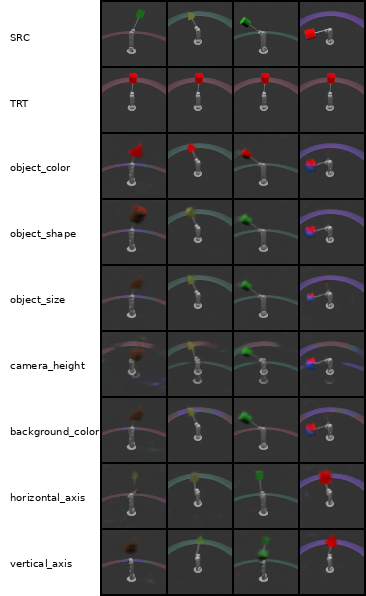

: 

In [ ]:
idx = torch.randperm(images.shape[0], dtype=int)
save_merge_mosaic_jpg(
    xfactors=xfactors,
    images=images,
    target_idx=idx[0],
    source_idxs=tuple(idx[1:5]),
    factors=range(7),
    save_path="merge_mosaic_mpi3d.jpg",
    left_margin=100,
    font_size=10
)